In this notebook, we will use a multi-layer perceptron to develop time series forecasting models.
The dataset used for the examples of this notebook is on air pollution measured by concentration of
particulate matter (PM) of diameter less than or equal to 2.5 micrometers. There are other variables
such as air pressure, air temparature, dewpoint and so on.
Two time series models are developed - one on air pressure and the other on pm2.5.
The dataset has been downloaded from UCI Machine Learning Repository.
https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

In [1]:
from __future__ import print_function
import os
import sys
import pandas as pd
from pandas import datetime
from pandas import read_csv
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import datetime

In [2]:
#set current working directory
os.chdir('/home/jmsmith20/Practical-Time-Series-Analysis')

In [3]:

#Read the dataset into a pandas.DataFrame
df = read_csv('Data-Files/theft_data-Copy1.csv')

In [4]:
print('Shape of the dataframe:', df.shape)

Shape of the dataframe: (210, 2)


In [5]:
#Let's see the first five rows of the DataFrame
df.head()

,Date,Thefts
0,01/2001,5125
1,02/2001,4429
2,03/2001,5024
3,04/2001,4887
4,05/2001,5148


In [6]:
"""
Rows having NaN values in column pm2.5 are dropped.
"""
#df.dropna(subset=['pm2.5'], axis=0, inplace=True)
#df.reset_index(drop=True, inplace=True)

'\nRows having NaN values in column pm2.5 are dropped.\n'

To make sure that the rows are in the right order of date and time of observations,
a new column datetime is created from the date and time related columns of the DataFrame.
The new column consists of Python's datetime.datetime objects. The DataFrame is sorted in ascending order
over this column.

Text(0.5,1,'Box plot of Thefts')

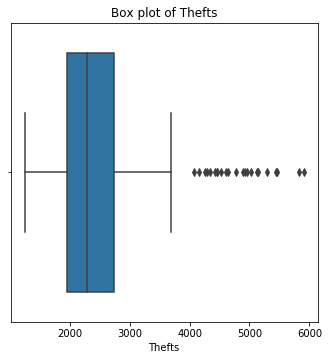

In [7]:
#Let us draw a box plot to visualize the central tendency and dispersion of PRES
plt.figure(figsize=(5.5, 5.5))
g = sns.boxplot(df['Thefts'])
g.set_title('Box plot of Thefts')

/home/jmsmith20/.local/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Text(0,0.5,'Number of thefts')

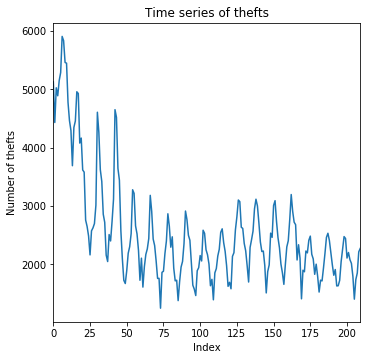

In [8]:
plt.figure(figsize=(5.5, 5.5))
g = sns.tsplot(df['Thefts'])
g.set_title('Time series of thefts')
g.set_xlabel('Index')
g.set_ylabel('Number of thefts')

Gradient descent algorithms perform better (for example converge faster) if the variables are wihtin range [-1, 1]. Many sources relax the boundary to even [-3, 3]. The pm2.5 variable is mixmax scaled to bound the tranformed variable within [0,1].

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df['scaled_Thefts'] = scaler.fit_transform(np.array(df['Thefts']).reshape(-1, 1))

/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Before training the model, the dataset is split in two parts - train set and validation set.
The neural network is trained on the train set. This means computation of the loss function, back propagation
and weights updated by a gradient descent algorithm is done on the train set. The validation set is
used to evaluate the model and to determine the number of epochs in model training. Increasing the number of 
epochs will further decrease the loss function on the train set but might not neccesarily have the same effect
for the validation set due to overfitting on the train set.Hence, the number of epochs is controlled by keeping
a tap on the loss function computed for the validation set. We use Keras with Tensorflow backend to define and train
the model. All the steps involved in model training and validation is done by calling appropriate functions
of the Keras API.

In [10]:
"""
Let's start by splitting the dataset into train and validation. The dataset's time period if from
Jan 1st, 2010 to Dec 31st, 2014. The first fours years - 2010 to 2013 is used as train and
2014 is kept for validation.
"""
#split_date = "05/2009" #datetime.datetime(year=2014, month=1, day=1, hour=0)
df_train = df[0:100] #df.loc[df['datetime']<split_date]
df_val = df[101:209] #df.loc[df['datetime']>=split_date]
print('Shape of train:', df_train.shape)
print('Shape of test:', df_val.shape)

Shape of train: (100, 3)
Shape of test: (108, 3)


In [11]:
#First five rows of train
df_train.head()

,Date,Thefts,scaled_Thefts
0,01/2001,5125,0.832618
1,02/2001,4429,0.683262
2,03/2001,5024,0.810944
3,04/2001,4887,0.781545
4,05/2001,5148,0.837554


In [12]:
#First five rows of validation
df_val.head()

,Date,Thefts,scaled_Thefts
101,06/2009,2055,0.173820
102,07/2009,2582,0.286910
103,08/2009,2529,0.275536
104,09/2009,2247,0.215021
105,10/2009,2162,0.196781


In [13]:
#Reset the indices of the validation set
df_val.reset_index(drop=True, inplace=True)

/home/jmsmith20/.local/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Text(0,0.5,'Scaled Thefts readings')

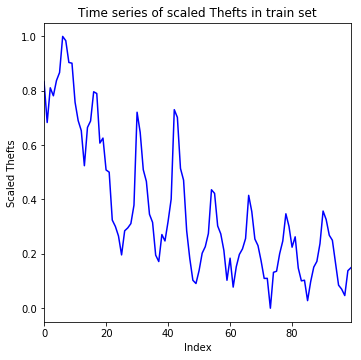

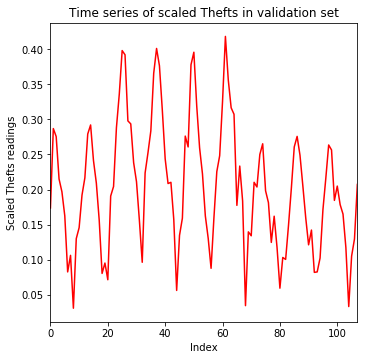

In [14]:
"""
The train and validation time series of scaled pm2.5 is also plotted.
"""

plt.figure(figsize=(5.5, 5.5))
g = sns.tsplot(df_train['scaled_Thefts'], color='b')
g.set_title('Time series of scaled Thefts in train set')
g.set_xlabel('Index')
g.set_ylabel('Scaled Thefts')

plt.figure(figsize=(5.5, 5.5))
g = sns.tsplot(df_val['scaled_Thefts'], color='r')
g.set_title('Time series of scaled Thefts in validation set')
g.set_xlabel('Index')
g.set_ylabel('Scaled Thefts readings')

Now we need to generate regressors (X) and target variable (y) for train and validation. 2-D array of regressor and 1-D array of target is created from the original 1-D array of columm standardized_pm2.5 in the DataFrames. For the time series forecasting model, Past seven days of observations are used to predict for the next day. This is equivalent to a AR(7) model. We define a function which takes the original time series and the number of timesteps in regressors as input to generate the arrays of X and y.

In [15]:
def makeXy(ts, nb_timesteps):
    """
    Input: 
           ts: original time series
           nb_timesteps: number of time steps in the regressors
    Output: 
           X: 2-D array of regressors
           y: 1-D array of target 
    """
    X = []
    y = []
    for i in range(nb_timesteps, ts.shape[0]):
        X.append(list(ts.loc[i-nb_timesteps:i-1]))
        y.append(ts.loc[i])
    X, y = np.array(X), np.array(y)
    return X, y

In [16]:
X_train, y_train = makeXy(df_train['scaled_Thefts'], 7)
print('Shape of train arrays:', X_train.shape, y_train.shape)

Shape of train arrays: (93, 7) (93,)


In [17]:
X_val, y_val = makeXy(df_val['scaled_Thefts'], 7)
print('Shape of validation arrays:', X_val.shape, y_val.shape)

Shape of validation arrays: (101, 7) (101,)


The input to convolution layers must be of shape (number of samples, number of timesteps, number of features per timestep). In this case we are modeling only pm2.5 hence number of features per timestep is one. Number of timesteps is seven and number of samples is same as the number of samples in X_train and X_val, which are reshaped to 3D arrays.

In [18]:
#X_train and X_val are reshaped to 3D arrays
X_train, X_val = X_train.reshape((X_train.shape[0], X_train.shape[1], 1)),\
                 X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
print('Shape of arrays after reshaping:', X_train.shape, X_val.shape)

Shape of arrays after reshaping: (93, 7, 1) (101, 7, 1)


Now we define the MLP using the Keras Functional API. In this approach a layer can be declared as the input of the following layer at the time of defining the next layer. 

In [19]:
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import ZeroPadding1D
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import AveragePooling1D
from keras.optimizers import SGD
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [20]:
#Define input layer which has shape (None, 7) and of type float32. None indicates the number of instances
input_layer = Input(shape=(7,1), dtype='float32')

ZeroPadding1D layer is added next to add zeros at the begining and end of each series. Zeropadding ensure that the downstream convolution layer does not reduce the dimension of the output sequences. Pooling layer, added after the convolution layer is used to downsampling the input.

In [21]:
#Add zero padding
zeropadding_layer = ZeroPadding1D(padding=1)(input_layer)

The first argument of Conv1D is the number of filters, which determine the number of features in the output. Second argument indicates length of the 1D convolution window. The third argument is strides and represent the number of places to shift the convolution window. Lastly, setting use_bias as True, add a bias value during computation of an output feature. Here, the 1D convolution can be thought of as generating local AR models over rolling window of three time units.

In [22]:
#Add 1D convolution layers
conv1D_layer1 = Conv1D(64, 3, strides=1, use_bias=True)(zeropadding_layer)
conv1D_layer2 = Conv1D(32, 3, strides=1, use_bias=True)(conv1D_layer1)

AveragePooling1D is added next to downsample the input by taking average over pool size of three with stride of one timesteps. The average pooling in this case can be thought of as taking moving averages over a rolling window of three time units. We have used average pooling instead of max pooling to generate the moving averages.

In [23]:
#Add AveragePooling1D layer
avgpooling_layer = AveragePooling1D(pool_size=3, strides=1)(conv1D_layer2)

The preceeding pooling layer returns 3D output. Hence before passing to the output layer, a Flatten layer is added. The Flatten layer reshapes the input to (number of samples, number of timesteps*number of features per timestep), which is then fed to the output layer

In [24]:
#Add Flatten layer
flatten_layer = Flatten()(avgpooling_layer)

In [25]:
#A couple of Dense layers are also added
dense_layer1 = Dense(32)(avgpooling_layer)
dense_layer2 = Dense(16)(dense_layer1)

In [26]:
dropout_layer = Dropout(0.2)(flatten_layer)

In [27]:
#Finally the output layer gives prediction for the next day's air pressure.
output_layer = Dense(1, activation='linear')(dropout_layer)

The input, dense and output layers will now be packed inside a Model, which is wrapper class for training and making
predictions. The box plot of pm2.5 shows the presence of outliers. Hence, mean absolute error (MAE) is used as absolute deviations suffer less fluctuations compared to squared deviations.

The network's weights are optimized by the Adam algorithm. Adam stands for adaptive moment estimation
and has been a popular choice for training deep neural networks. Unlike, stochastic gradient descent, adam uses
different learning rates for each weight and separately updates the same as the training progresses. The learning rate of a weight is updated based on exponentially weighted moving averages of the weight's gradients and the squared gradients.

In [28]:
ts_model = Model(inputs=input_layer, outputs=output_layer)
ts_model.compile(loss='mean_absolute_error', optimizer='adam')#SGD(lr=0.001, decay=1e-5))
ts_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 7, 1)              0         
_________________________________________________________________
zero_padding1d_1 (ZeroPaddin (None, 9, 1)              0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7, 64)             256       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 32)             6176      
_________________________________________________________________
average_pooling1d_1 (Average (None, 3, 32)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 96)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 96)                0         
__________

The model is trained by calling the fit function on the model object and passing the X_train and y_train. The training 
is done for a predefined number of epochs. Additionally, batch_size defines the number of samples of train set to be
used for a instance of back propagation.The validation dataset is also passed to evaluate the model after every epoch
completes. A ModelCheckpoint object tracks the loss function on the validation set and saves the model for the epoch,
at which the loss function has been minimum.

In [29]:
save_weights_at = os.path.join('Data-Files', 'Theft_data_PM2.5_1DConv_weights.{epoch:02d}-{val_loss:.4f}.hdf5')
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            period=1)
ts_model.fit(x=X_train, y=y_train, batch_size=16, epochs=20,
             verbose=1, callbacks=[save_best], validation_data=(X_val, y_val),
             shuffle=True)

Train on 93 samples, validate on 101 samples
Epoch 1/20
93/93 [==============================] - 0s 3ms/step - loss: 0.2486 - val_loss: 0.1265
Epoch 2/20
93/93 [==============================] - 0s 247us/step - loss: 0.1875 - val_loss: 0.0964
Epoch 3/20
93/93 [==============================] - 0s 245us/step - loss: 0.1440 - val_loss: 0.0883
Epoch 4/20
93/93 [==============================] - 0s 248us/step - loss: 0.1367 - val_loss: 0.0811
Epoch 5/20
93/93 [==============================] - 0s 245us/step - loss: 0.1336 - val_loss: 0.0854
Epoch 6/20
93/93 [==============================] - 0s 246us/step - loss: 0.1195 - val_loss: 0.0671
Epoch 7/20
93/93 [==============================] - 0s 225us/step - loss: 0.1209 - val_loss: 0.0631
Epoch 8/20
93/93 [==============================] - 0s 231us/step - loss: 0.1056 - val_loss: 0.0665
Epoch 9/20
93/93 [==============================] - 0s 214us/step - loss: 0.0965 - val_loss: 0.0580
Epoch 10/20
93/93 [==============================] - 0s 2

Prediction are made for the pm2.5 from the best saved model. The model's predictions, which are on the standardized  pm2.5, are inverse transformed to get predictions of original pm2.5.

In [30]:
best_model = load_model(os.path.join('Data-Files', 'Theft_data_PM2.5_1DConv_weights.20-0.0404.hdf5'))
preds = best_model.predict(X_val)
pred_pm25 = scaler.inverse_transform(preds)
pred_pm25 = np.squeeze(pred_pm25)

In [31]:
from sklearn.metrics import mean_absolute_error

In [32]:
mae = mean_absolute_error(df_val['Thefts'].loc[7:], pred_pm25)
print('MAE for the validation set:', round(mae, 4))

MAE for the validation set: 188.3558


Text(0.5,0,'Index')

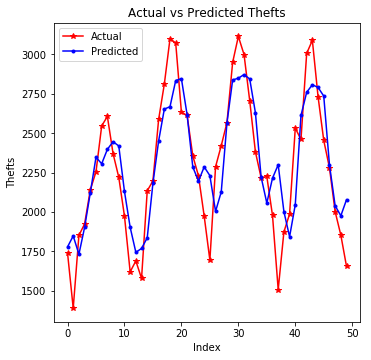

In [33]:
#Let's plot the first 50 actual and predicted values of pm2.5.
plt.figure(figsize=(5.5, 5.5))
plt.plot(range(50), df_val['Thefts'].loc[7:56], linestyle='-', marker='*', color='r')
plt.plot(range(50), pred_pm25[:50], linestyle='-', marker='.', color='b')
plt.legend(['Actual','Predicted'], loc=2)
plt.title('Actual vs Predicted Thefts')
plt.ylabel('Thefts')
plt.xlabel('Index')